# Roboflow Dataset Analysis with Filoma

This tutorial demonstrates how to use **Filoma** to analyze a computer vision dataset downloaded from Roboflow. We will cover:
1. Downloading a dataset using the Roboflow API.
2. Probing the dataset structure and metadata using Filoma.
3. Using Polars for efficient data manipulation.
4. Visualizing file size distributions across dataset splits.

## 1. Setup and Installation

First, we'll install the necessary dependencies and set up the environment.

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

!uv pip install roboflow seaborn matplotlib polars python-dotenv --quiet

In [2]:
import os
from pathlib import Path

import filoma as flm
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from dotenv import load_dotenv
from roboflow import Roboflow
import random


## 2. Download Dataset from Roboflow

To use this notebook, you should have a Roboflow API key. 

**Recommendation:** Create a `.env` file in the root of your project and add your key there:
```text
ROBOFLOW_API_KEY=your_actual_api_key_here
```
The code below will automatically load it.

In [3]:
# Load environment variables from .env file
load_dotenv()

# Access your Roboflow API Key
api_key = os.getenv("ROBOFLOW_API_KEY", "YOUR_API_KEY_HERE")

rf = Roboflow(api_key=api_key)
project = rf.workspace("augmented-startups").project("weeds-nxe1w")
version = project.version(3)
dataset = version.download("multiclass")

# Define dataset path
dataset_path = Path("./Weeds-3/").resolve()
print(f"Dataset downloaded to: {dataset_path}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /home/kalfasy/repos/filoma/notebooks/Weeds-3


## 3. Profiling the Dataset with Filoma

Filoma makes it incredibly easy to scan a directory and create a Polars DataFrame containing file, file-path, and image metadata information. We can make use of this to analyze our Roboflow dataset.

In [ ]:
# Use filoma's probe_to_df to create a DataFrame with file metadata
# and simply filter for .jpg images
df = flm.probe_to_df(dataset_path.as_posix()).filter_by_extension(".jpg")

# Extract the dataset split (train/valid/test) from the "parent" directory name
# since all images are stored in respective subdirectories
df = df.with_columns(split=pl.col("parent").str.split("/").list.last())

# And we can now separate the DataFrame into different splits
df_train = df.filter(pl.col("split") == "train")
df_val = df.filter(pl.col("split") == "valid")
df_test = df.filter(pl.col("split") == "test")

print("Number of images in each split:")
print(f" - Train: {df_train.shape[0]}")
print(f" - Validation: {df_val.shape[0]}")
print(f" - Test: {df_test.shape[0]}")

2025-12-30 22:21:20.462 | DEBUG    | filoma.directories.directory_profiler:__init__:381 - Interactive environment detected, disabling progress bars to avoid conflicts
2025-12-30 22:21:20.462 | INFO     | filoma.directories.directory_profiler:probe:474 - Starting directory analysis of '/home/kalfasy/repos/filoma/notebooks/Weeds-3' using 🦀 Rust (Parallel) implementation


2025-12-30 22:21:20.532 | SUCCESS  | filoma.directories.directory_profiler:probe:490 - Directory analysis completed in 0.07s - Found 4,212 items (4,208 files, 4 folders) using 🦀 Rust (Parallel)


Number of images in each split:
 - Train: 3664
 - Validation: 359
 - Test: 180


## 4. Analyzing File Sizes

We can easily explore data sizes using the `size_bytes` column provided by Filoma.

In [ ]:
# Let's compute the total size of each split
def get_stats(df, label):
    """
    Compute and print the total size of files in the given DataFrame.
    """
    total_bytes = df.select(pl.col("size_bytes").sum()).item()
    total_mb = total_bytes / (1024 * 1024)
    print(f"{label} total size: {total_mb:.2f} MB")
    return total_mb


# Get stats for each split
get_stats(df_train, "Training")
get_stats(df_val, "Validation")
get_stats(df_test, "Test");

Training total size: 258.30 MB
Validation total size: 20.01 MB
Test total size: 9.91 MB


In [18]:
# Let's get the average file size per split
avg_train_size = df_train.select(pl.col("size_bytes").mean()).item() / (1024 * 1024)
avg_val_size = df_val.select(pl.col("size_bytes").mean()).item() / (1024 * 1024)
avg_test_size = df_test.select(pl.col("size_bytes").mean()).item() / (1024 * 1024)
print("Average file size (MB):")
print(f" - Train: {avg_train_size:.2f} MB")
print(f" - Validation: {avg_val_size:.2f} MB")
print(f" - Test: {avg_test_size:.2f} MB")

Average file size (MB):
 - Train: 0.07 MB
 - Validation: 0.06 MB
 - Test: 0.06 MB


This looks a bit suspicious already, let's plot the density distributions of file sizes across the different splits to visualize this better.

## 5. Visualizing the Distribution

Finally, let's visualize the density of file sizes across our splits.

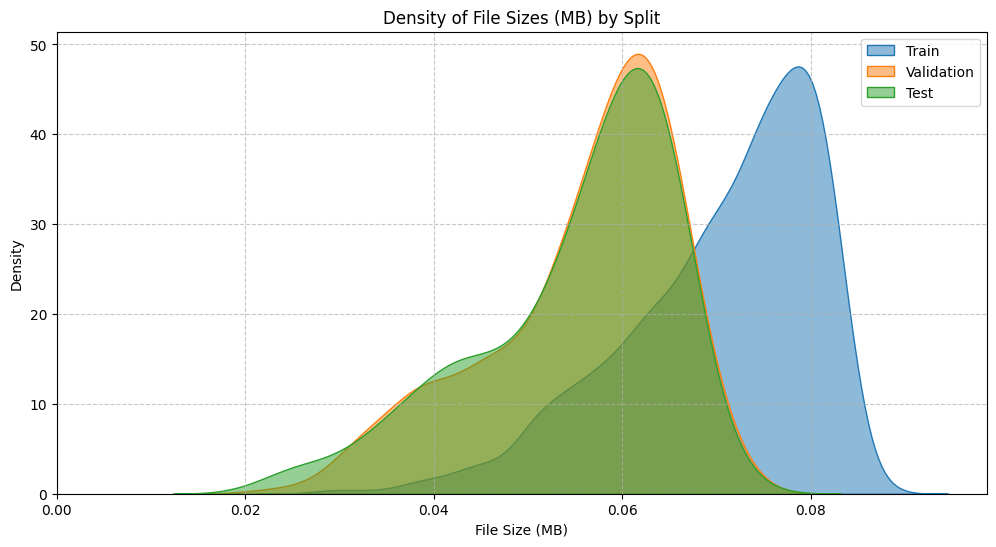

In [ ]:
# Convert size_bytes to MB for plotting
df = df.with_columns((pl.col("size_bytes") / (1024 * 1024)).alias("size_MB"))
train_mb = df.filter(pl.col("split") == "train").select("size_MB").to_series().to_list()
val_mb = df.filter(pl.col("split") == "valid").select("size_MB").to_series().to_list()
test_mb = df.filter(pl.col("split") == "test").select("size_MB").to_series().to_list()

plt.figure(figsize=(12, 6))

sns.kdeplot(train_mb, label="Train", fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(val_mb, label="Validation", fill=True, common_norm=False, alpha=0.5)
sns.kdeplot(test_mb, label="Test", fill=True, common_norm=False, alpha=0.5)

plt.xlabel("File Size (MB)")
plt.ylabel("Density")
plt.title("Density of File Sizes (MB) by Split")
plt.xlim(left=0)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

We see that the training set has larger files on average compared to validation and test sets. This insight can help in understanding the dataset's characteristics and planning for model training and evaluation. Let's plot some random images from each split to get a better sense of the data and why those size differences might exist.

# 6. Plotting random images from train/val/test splits

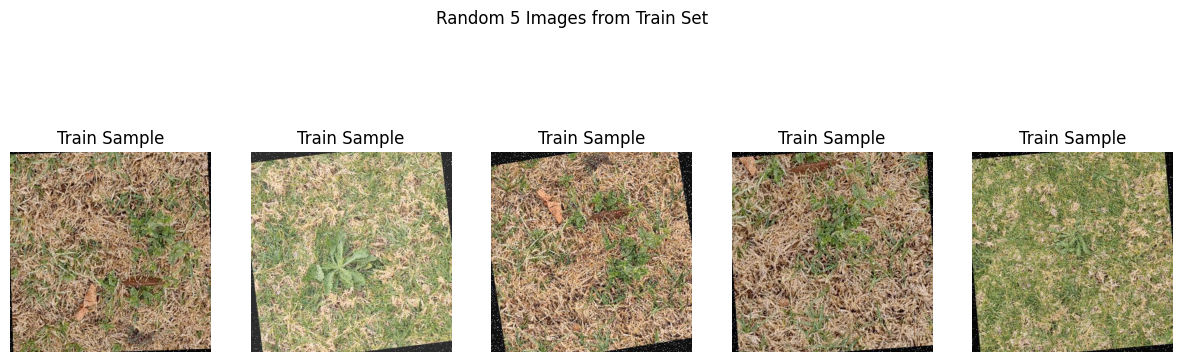

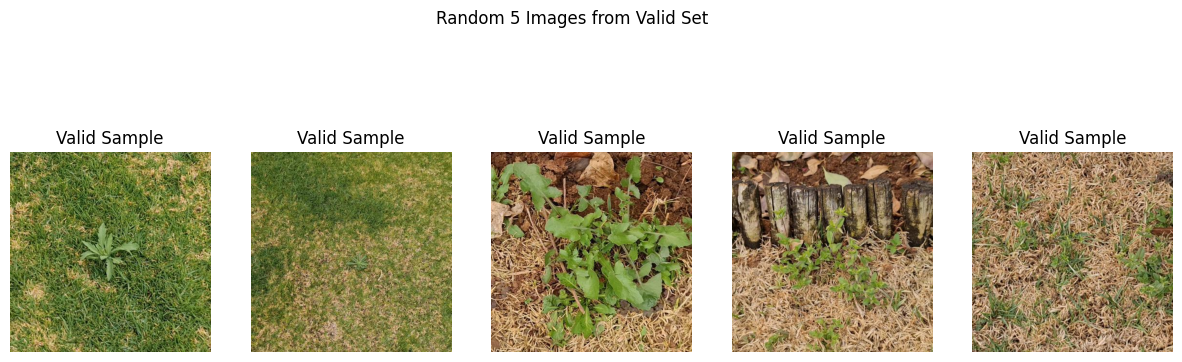

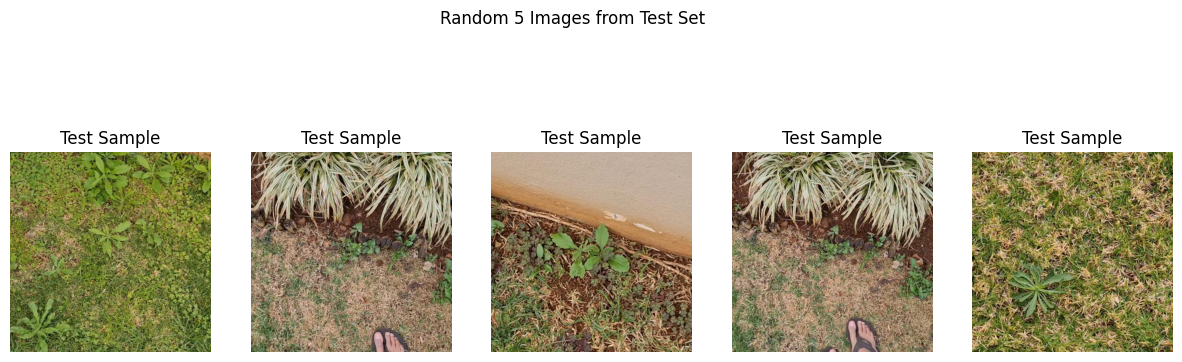

In [ ]:
def plot_random_images(df, split, num_images=5):
    sampled_df = df.filter(pl.col("split") == split).sample(n=num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for ax, row in zip(axes, sampled_df.iter_rows()):
        img_path = row[df.get_column_index("path")]
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{split.capitalize()} Sample")
    plt.suptitle(f"Random {num_images} Images from {split.capitalize()} Set")
    plt.show()


plot_random_images(df, "train", num_images=5)
plot_random_images(df, "valid", num_images=5)
plot_random_images(df, "test", num_images=5)

The training images seem to have augmentations applied, which could explain their larger file sizes..